In [2]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# curr_dir = os.path.dirname(os.path.abspath(__file__))
#parent_dir = os.path.dirname(curr_dir)
#sys.path.append(parent_dir)

file_path = "../data/external/main_data.hdf5"

# ---------------- VARIABLES TO STORE
all_actions = []
all_observations = []
all_rewards_to_go = []
all_time_to_go = []
# -----------------------------------

with h5py.File(file_path, "r+") as f:
    for key in f.keys():
        #del episode_87["key-id"] removing a thing
        
        curr_episode = f[key]

        # split observations into the useful and useless observations (1 more observation than action) if not done before
        if "removed_last_obervation" not in curr_episode.keys():
            curr_episode["removed_last_obervation"] = curr_episode["observations"][-1]
            curr_episode["observations_data"] = curr_episode["observations"][:-1]

        # Inspect data in each attribute
        actions = curr_episode["actions"][:]
        infos = curr_episode["infos"]
        observations = curr_episode["observations_data"][:]
        rewards = curr_episode["rewards"][:]
        terminations = curr_episode["terminations"][:]
        truncations = curr_episode["truncations"][:]

        reward_sum = np.sum(rewards)
        rewards_to_go = np.zeros_like(rewards)
        time_to_go = np.zeros_like(rewards)
        for i in range (len(rewards)):
            rewards_to_go[i] = reward_sum
            reward_sum -= rewards[i]
            time_to_go[i] = len(rewards) - i
        # save the rewards as labels
        
        if "rewards_to_go" not in curr_episode.keys():
            curr_episode["rewards_to_go"] = rewards_to_go
            curr_episode["time_to_go"] = time_to_go

        # save the stuff
        all_actions.append(actions)
        all_observations.append(observations)
        all_rewards_to_go.append(rewards_to_go)
        all_time_to_go.append(time_to_go)
        

    print(rewards[-5:], rewards_to_go[-5:], time_to_go[-5:])
    # Dimensions:
    print(f"Keys in {key}:", list(curr_episode.keys()))
    print(f"{key} Action dimensions: {actions.shape}")
    print(f"Observation dimensions: {observations.shape}")
    print(f"Reward dimensions: {rewards.shape}")
    print(f"Termination dimensions: {terminations.shape}")
    print(f"Truncation dimensions: {truncations.shape}")

[4.53705551 4.75870536 5.20804495 5.30901434 4.93248319] [24.74530334 20.20824784 15.44954248 10.24149753  4.93248319] [5. 4. 3. 2. 1.]
Keys in episode_999: ['actions', 'infos', 'observations', 'observations_data', 'removed_last_obervation', 'rewards', 'rewards_to_go', 'terminations', 'time_to_go', 'truncations']
episode_999 Action dimensions: (1000, 8)
Observation dimensions: (1000, 105)
Reward dimensions: (1000,)
Termination dimensions: (1000,)
Truncation dimensions: (1000,)


In [2]:
print(len(all_actions))

1078


In [6]:
#store the rewards_to_go in a seperate array for data analysis
rewards_to_go_list = all_rewards_to_go[:]

In [ ]:
# combine the data into single vectors
all_actions = np.concatenate(all_actions, axis=0)
all_observations = np.concatenate(all_observations, axis=0)
all_rewards_to_go = np.concatenate(all_rewards_to_go, axis=0)
all_time_to_go = np.concatenate(all_time_to_go, axis=0)

In [ ]:
# create a new dataset with all the values at once
output_file_path = "../data/processed/concatenated_data.hdf5"

with h5py.File(output_file_path, "w") as f:
    group = f.create_group("concatenated_data")

    # Save the concatenated data into the new group
    group.create_dataset("actions", data=all_actions)
    group.create_dataset("observations", data=all_observations)
    group.create_dataset("rewards_to_go", data=all_rewards_to_go)
    group.create_dataset("time_to_go", data=all_time_to_go)

print(f"Concatenated data saved under 'concatenated_data' in {output_file_path}")
print(f"Actions shape: {all_actions.shape}")
print(f"Observations shape: {all_observations.shape}")
print(f"Rewards_to_go shape: {all_rewards_to_go.shape}")
print(f"Time_to_go shape: {all_time_to_go.shape}")

Concatenated data saved under 'concatenated_data' in ../data/processed/concatenated_data.hdf5
Actions shape: (999382, 8)
Observations shape: (999382, 105)
Rewards_to_go shape: (999382,)
Time_to_go shape: (999382,)
Rewards shape: (999382,)


In [ ]:
len(rewards_to_go_list)

1078

In [19]:
episodic_dr_signal = [episode_returns[0] for episode_returns in rewards_to_go_list]
mid_episodic_dr_signal = [episode_returns[len(episode_returns)//2] for episode_returns in rewards_to_go_list]

In [16]:
print(len(episodic_dr_signal), episodic_dr_signal[0:2])

1078 [np.float64(3716.237251145434), np.float64(696.4046300836451)]


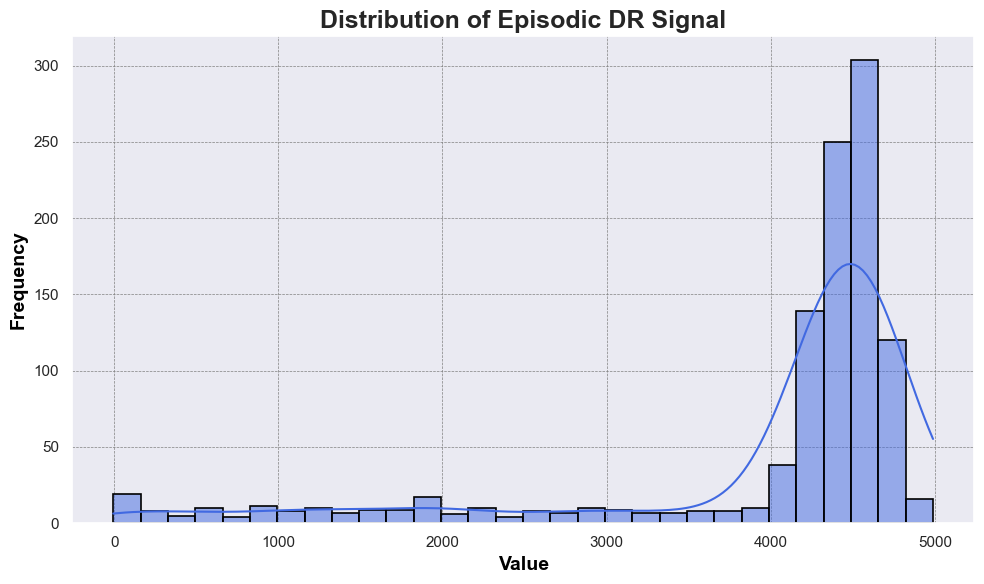

In [ ]:
sns.set_theme(style="darkgrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the histogram with KDE
sns.histplot(episodic_dr_signal, bins=30, kde=True, color='royalblue', edgecolor='black', linewidth=1.2)

plt.title('Distribution of Episodic DR Signal', fontsize=18, weight='bold')
plt.xlabel('Value', fontsize=14, weight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, weight='bold', color='black')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

In [23]:
#this looks quite bad, and potentially requires exploration steps to ensure learning sub-optimal pathways as well
#to see how bad it is, lets check the distributions:
print("percentage of dr between 0 and 4000:", len([x for x in episodic_dr_signal if x < 4000]) / len(episodic_dr_signal))
print("percentage of dr between 4200 and 4800:", len([x for x in episodic_dr_signal if x > 4200 and x < 4800]) / len(episodic_dr_signal))

percentage of dr between 0 and 4000: 0.19851576994434136
percentage of dr between 4200 and 4800: 0.7226345083487941


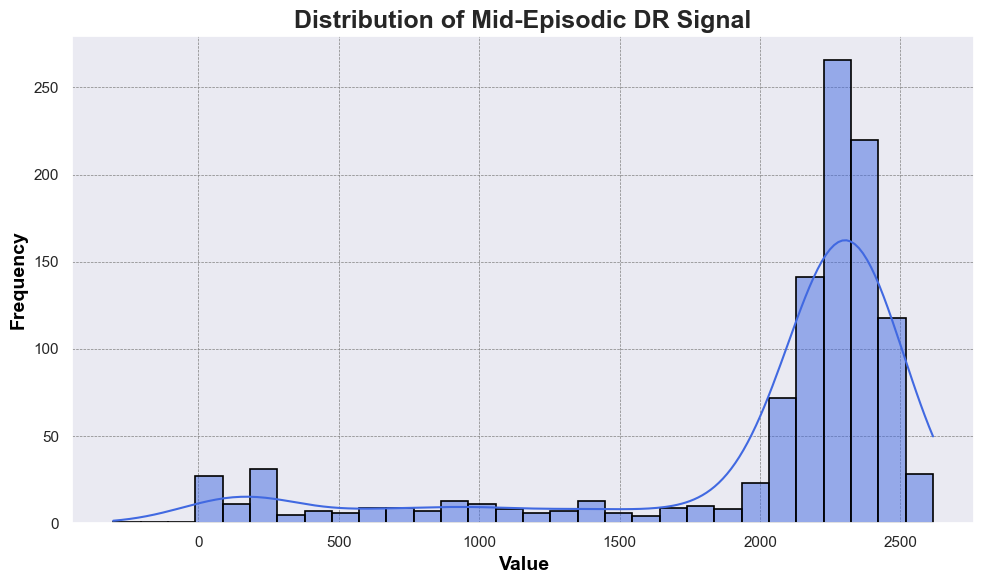

In [ ]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))

# Plot the histogram with KDE
sns.histplot(mid_episodic_dr_signal, bins=30, kde=True, color='royalblue', edgecolor='black', linewidth=1.2)


plt.title('Distribution of Mid-Episodic DR Signal', fontsize=18, weight='bold')
plt.xlabel('Value', fontsize=14, weight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, weight='bold', color='black')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

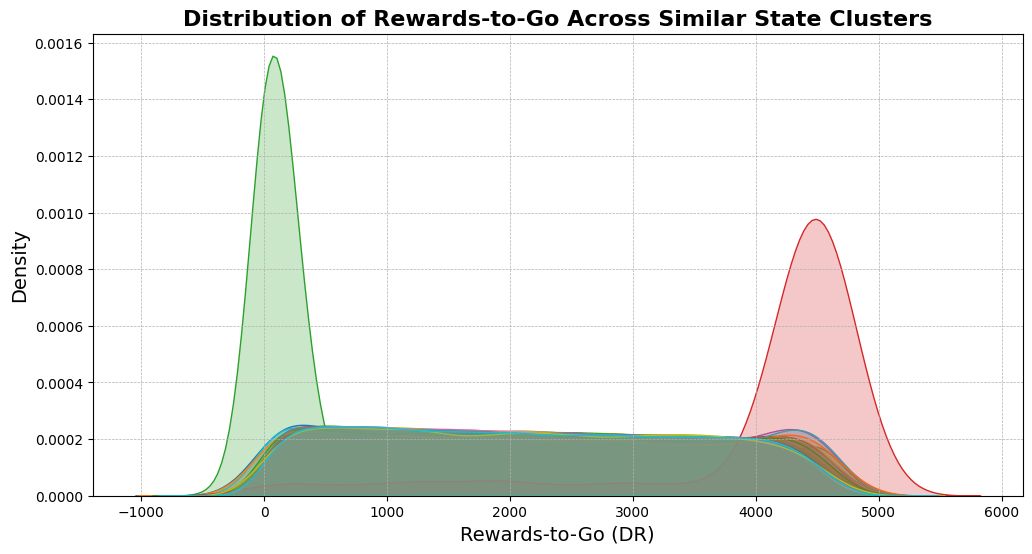

In [ ]:
from sklearn.cluster import KMeans

# Load the dataset
file_path = "../data/processed/concatenated_data.hdf5"
with h5py.File(file_path, "r") as f:
    observations = np.array(f["concatenated_data/observations"])
    rewards_to_go = np.array(f["concatenated_data/rewards_to_go"])


num_clusters = 30  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
state_clusters = kmeans.fit_predict(observations)

# Aggregate rewards-to-go for each cluster
clustered_dr = {i: [] for i in range(num_clusters)}
for idx, cluster in enumerate(state_clusters):
    clustered_dr[cluster].append(rewards_to_go[idx])

plt.figure(figsize=(12, 6))
for cluster_id, dr_values in clustered_dr.items():
    sns.kdeplot(dr_values, label=f"Cluster {cluster_id}", fill=True)

plt.xlabel("Rewards-to-Go (DR)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Distribution of Rewards-to-Go Across Similar State Clusters", fontsize=16, weight="bold")
#plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()
plt.savefig("rewards_to_go_per_cluster.png")

Observations shape: (999382, 105) Rewards-to-Go shape: (999382,)


C:\Users\12saw\AppData\Local\Temp\ipykernel_26240\351367319.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_labels, palette="viridis")


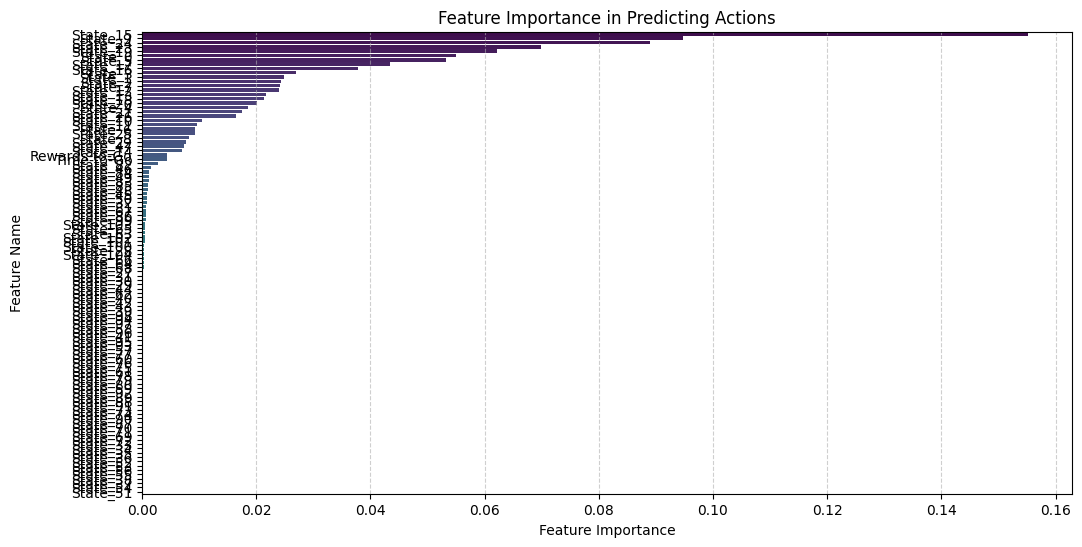

In [ ]:
# looks better, lets test for feature importances
from sklearn.ensemble import RandomForestRegressor

print(f"Observations shape: {all_observations.shape}", f"Rewards-to-Go shape: {all_rewards_to_go.shape}")
X = np.hstack((all_observations, all_rewards_to_go.reshape(-1, 1), all_time_to_go.reshape(-1, 1)))
y = all_actions 

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

In [ ]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create feature labels
num_state_vars = all_observations.shape[1]
feature_labels = [f"State_{i}" for i in range(num_state_vars)] + ["Rewards-to-Go", "Time-to-Go"]

# Sort features by importance (take only top 10)
sorted_indices = np.argsort(feature_importances)[::-1][:30]
sorted_importances = feature_importances[sorted_indices]
sorted_labels = [feature_labels[i] for i in sorted_indices]
colors = ['red' if label in ['Rewards-to-Go', 'Time-to-Go'] else 'royalblue' for label in sorted_labels]

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_importances, y=sorted_labels, palette="viridis", colors=colors)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Predicting Actions")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()
plt.savefig("feature_importance_random_forest.png")

NameError: name 'rf' is not defined